In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from IPython.display import display

## Initialize student pool based on above parameters
def disadvantaged_random():
    val = np.random.random()
    if (val) >= 0.67:
        return 1
    else:
        return 0

def advantaged_random():
    val = np.random.random()
    if (val) >= 0.34:
        return 1
    else: 
        return 0

def print_equity(num_A,num_D):
    # print('assessing equity: ')
    # print('% of students from A: ',100*(num_A/(num_A+num_D)))
    # print('% of students from D: ',100*(num_D/(num_A+num_D)))

    return num_D/(num_A+num_D)

# Meeting Todo (2/11/25):
1. Meaning of all of the cases
2. What results do we expect from each of the cases?
3. How should we implement Part I Cases 3/4?
4. How should we standardize display for efficiency and equity?

# Part I



Approach:

1. Set critical parameters:
- Total number of students in applicant pool: 100
- Number of students in advantaged pool: 50
- Number of students in disadvantaged pool: 50
- Probability a student has x_i = 1 for x in [1,2] if from advantaged group: 2/3
- Probability a student has x_i = 1 for x in [1,2] if from disadvantaged group: 1/3

2. Initialize student pool based on above parameters.
- Note: can use numpy.random() to generate random numbers between 0 and 1, allows us to model simple probabilities.

3. For each of the four scenarios, generate table of student f-value rankings based on x_1 and x_2 for a given student, and include information on whether they are from the advantaged group (A) or disadvantaged group (D).
- Scenario 1: Use both x_1 and x_2 information but not group information
- Scenario 2: Do not use x_2 and do not use group membership nformation
- Scenario 3: Do not use x_2, but use group membership information.
- Scenario 4: Use x_2 for students in D but do not use group membership information otherwise.

4. Calculate the average f-value for the top 5/18 of the students in the pool for each scenario (efficiency of algorithm). -> 27 students

5. Assess the proportion of admitted students in A and D and compare to the proportion of students in the applicant pool from A and D (equity of algorithm).

6. Repeat above analysis (steps 2-5) for a large number of iterations to check if the algorithm converges to the theoretical expectation.

In [10]:
def run_admission_iter(case,students_df,num_admitted_students):
    # admissions
    match case:
        case 1:
            true_f_df = students_df[students_df['f'] == 1]
            false_f_df = students_df[students_df['f'] == 0]
        case 2:
            true_f_df = students_df[students_df['x_1'] == 1]
            false_f_df = students_df[students_df['x_1'] == 0]

    # get number of students in top rank
    num_top_rank = len(true_f_df)
    if num_admitted_students < num_top_rank:
        students_to_admit = np.random.choice(true_f_df.index.values,size=num_admitted_students,replace=False)
        admitted_students_df = true_f_df.loc[students_to_admit]
    elif num_admitted_students == num_top_rank:
        admitted_students_df = true_f_df
    elif num_admitted_students > num_top_rank:
        admitted_students_df = true_f_df
        students_to_admit = np.random.choice(false_f_df.index.values,size=num_admitted_students-num_top_rank,replace=False)
        admitted_students_df = pd.concat([admitted_students_df,false_f_df.loc[students_to_admit]])

    # percentage of students that are admitted with f=1
    # print('assessing efficiency: ')
    efficiency = np.mean(admitted_students_df["f"])
    # print("% of admitted students with f=1 (efficiency): ",efficiency)

    # percentage of studnets that are admitted from each group
    admitted_df = admitted_students_df["g"]
    num_A = admitted_df.eq('A').sum()
    num_D = admitted_df.eq('D').sum()
    equity = print_equity(num_A,num_D)

    return {'efficiency':efficiency,'equity':equity}

In [11]:
def scenario_3(case,students_df,num_admitted_students):

    true_f_A_df = students_df[(students_df['x_1'] == 1) & (students_df['g'] == 'A')]
    true_f_D_df = students_df[(students_df['x_1'] == 1) & (students_df['g'] == 'D')]
    false_f_A_df = students_df[(students_df['x_1'] == 0) & (students_df['g'] == 'A')]
    false_f_D_df = students_df[(students_df['x_1'] == 0) & (students_df['g'] == 'D')]
    false_f_df = false_f_A_df+false_f_D_df

    num_rank_1 = len(true_f_A_df)
    num_rank_2 = len(true_f_D_df)
    rank_1 = true_f_A_df
    rank_2 = true_f_D_df
    num_rank_3 = len(false_f_df)

    if num_admitted_students < num_rank_1:
        students_to_admit = np.random.choice(rank_1.index.values,size=num_admitted_students,replace=False)
        admitted_students_df = rank_1.loc[students_to_admit]
    elif num_admitted_students == num_rank_1:
        admitted_students_df = rank_1
    elif num_admitted_students < (num_rank_1+num_rank_2) and num_admitted_students > num_rank_1:
        admitted_students_df = rank_1
        students_to_admit = np.random.choice(rank_2.index.values,size=num_admitted_students-num_rank_1,replace=False)
        admitted_students_df = pd.concat([admitted_students_df,rank_2.loc[students_to_admit]])
    elif num_admitted_students == (num_rank_1+num_rank_2):
        admitted_students_df = rank_1
        admitted_students_df = pd.concat([admitted_students_df,rank_2])
    elif num_admitted_students < (num_rank_1+num_rank_2+num_rank_3) and num_admitted_students > (num_rank_1+num_rank_2):
        admitted_students_df = rank_1
        admitted_students_df = pd.concat([admitted_students_df,rank_2])
        students_to_admit = np.random.choice(false_f_df.index.values,size=num_admitted_students-(num_rank_1+num_rank_2),replace=False)
        admitted_students_df = pd.concat([admitted_students_df,false_f_df.loc[students_to_admit]])
    elif num_admitted_students == (num_rank_1+num_rank_2+num_rank_3):
        admitted_students_df = rank_1
        admitted_students_df = pd.concat([admitted_students_df,rank_2])
        admitted_students_df = pd.concat([admitted_students_df,false_f_df])

    efficiency = np.mean(admitted_students_df["f"])
 
    admitted_group_df = admitted_students_df["g"]
    num_A = admitted_group_df.eq('A').sum()
    num_D = admitted_group_df.eq('D').sum()
    equity = print_equity(num_A,num_D)

    return {'efficiency':efficiency,'equity':equity}

In [12]:
def scenario_4(case,students_df,num_admitted_students):

    true_f_D_df = students_df[(students_df['f'] == 1) & (students_df['g'] == 'D')]
    true_x_1_df = students_df[(students_df['x_1'] == 1)]
    false_x_1_df = students_df[(students_df['x_1'] == 0)]

    # get number of students in top rank
    num_rank_1 = len(true_f_D_df)
    num_rank_2 = len(true_x_1_df)
    num_rank_3 = len(false_x_1_df)

    if num_admitted_students < num_rank_1:
        students_to_admit = np.random.choice(true_f_D_df.index.values,size=num_admitted_students,replace=False)
        admitted_students_df = true_f_D_df.loc[students_to_admit]
    elif num_admitted_students == num_rank_1:
        admitted_students_df = true_f_D_df
    elif num_admitted_students < (num_rank_1+num_rank_2) and num_admitted_students > num_rank_1:
        admitted_students_df = true_f_D_df
        students_to_admit = np.random.choice(true_x_1_df.index.values,size=num_admitted_students-num_rank_1,replace=False)
        admitted_students_df = pd.concat([admitted_students_df,true_x_1_df.loc[students_to_admit]])
    elif num_admitted_students == (num_rank_1+num_rank_2):
        admitted_students_df = true_f_D_df
        admitted_students_df = pd.concat([admitted_students_df,true_x_1_df])
    elif num_admitted_students < (num_rank_1+num_rank_2+num_rank_3) and num_admitted_students > (num_rank_1+num_rank_2):
        admitted_students_df = true_f_D_df
        admitted_students_df = pd.concat([admitted_students_df,true_x_1_df])
        students_to_admit = np.random.choice(false_x_1_df.index.values,size=num_admitted_students-(num_rank_1+num_rank_2),replace=False)
        admitted_students_df = pd.concat([admitted_students_df,false_x_1_df.loc[students_to_admit]])
    elif num_admitted_students >= (num_rank_1+num_rank_2+num_rank_3):
        admitted_students_df = students_df

    # percentage of students that are admitted with f=1
    # print('assessing efficiency: ')
    efficiency = np.mean(admitted_students_df["f"])
    # print("% of admitted students with f=1 (efficiency): ",efficiency)

    # percentage of studnets that are admitted from each group
    admitted_group_df = admitted_students_df["g"]
    num_A = admitted_group_df.eq('A').sum()
    num_D = admitted_group_df.eq('D').sum()
    equity = print_equity(num_A,num_D)

    return {'efficiency':efficiency,'equity':equity}

Note: Perfect efficiency is efficiency = 1

Note: Perfect equity is equity = 0.5; equity > 0.5 means group A overrepresentation; equity < 0.5 means group D overrepresentation

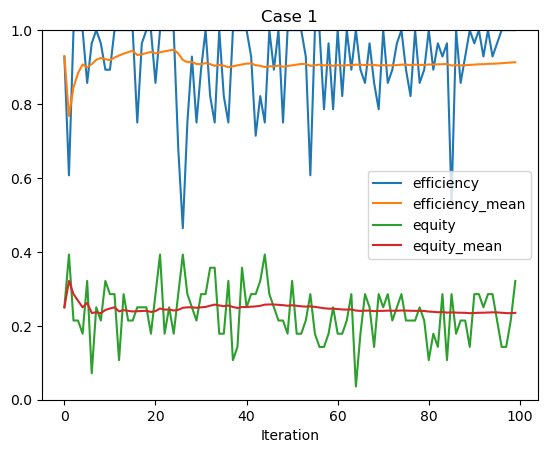

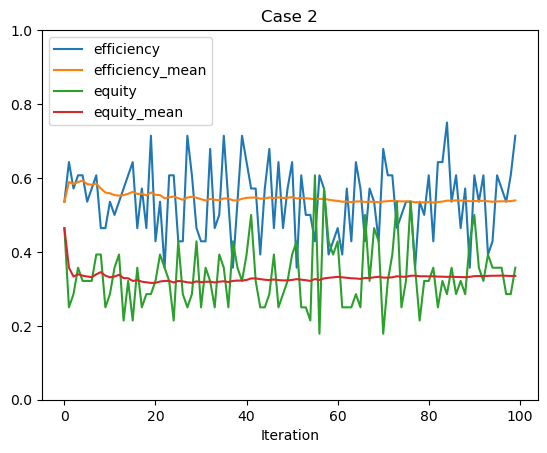

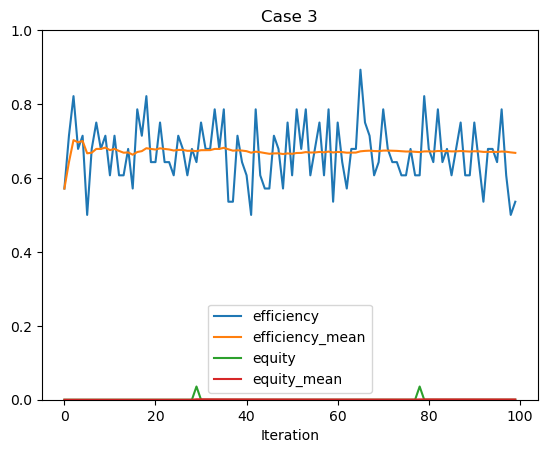

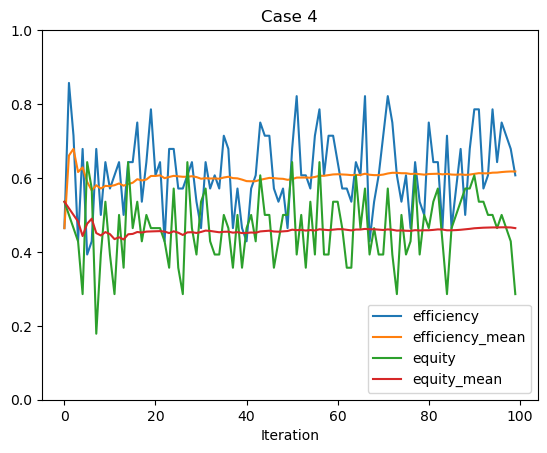

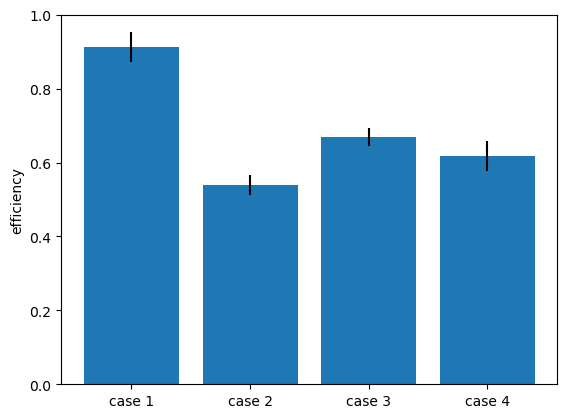

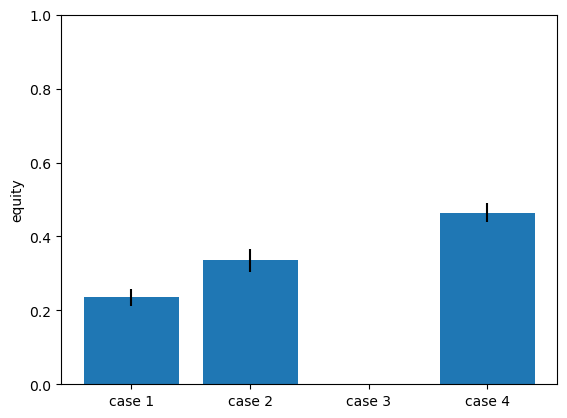

In [13]:
scenarios = [1,2,3,4]

eff_mean_arr = []
eff_mean_err_arr = []
eq_mean_arr = []
eq_mean_err_arr = []
case_labels = ['case 1','case 2','case 3','case 4']
gen = range(100)

for scenario in scenarios:
    efficiency = []
    efficiency_mean = []
    equity = []
    equity_mean = []

    match scenario:
        case 1:
            func = run_admission_iter
        case 2:
            func = run_admission_iter
        case 3:
            func = scenario_3
        case 4:
            func = scenario_4

    for x in gen:
        d_x1 = []
        d_x2 = []
        a_x1 = []
        a_x2 = []
        for x in range(0,50):
            d_x1.append(disadvantaged_random())
            d_x2.append(disadvantaged_random())
            a_x1.append(advantaged_random())
            a_x2.append(advantaged_random())

        x_1 = a_x1 + d_x1
        x_2 = a_x2 + d_x2
        g = ['A' for x in range(0,50)] + ['D' for x in range(0,50)]

        students_df = pd.DataFrame({"x_1":x_1,
                                    "x_2":x_2,
                                    "g":g })
        students_df["f"] = students_df.apply(lambda x: 1 if (x["x_1"]==1 and x["x_2"]==1) else 0, axis=1)

        num_admitted_students = round(100*5/18)

        res = func(scenario,students_df=students_df,num_admitted_students=num_admitted_students)
        efficiency.append(res['efficiency'])
        efficiency_mean.append(np.mean(efficiency))
        equity.append(res['equity'])
        equity_mean.append(np.mean(equity))

    plt.plot(gen,efficiency,label="efficiency")
    plt.plot(gen,efficiency_mean,label="efficiency_mean")
    plt.plot(gen,equity,label="equity")
    plt.plot(gen,equity_mean,label="equity_mean")
    plt.xlabel("Iteration")
    plt.legend()
    plt.title('Case '+str(scenario))
    plt.ylim((0,1))
    plt.show()

    eff_mean_arr.append(efficiency_mean[-1])
    eff_mean_err_arr.append(np.std(efficiency_mean)*2)
    eq_mean_arr.append(equity_mean[-1])
    eq_mean_err_arr.append(np.std(equity_mean)*2)

    # print('efficiency mean: ',efficiency_mean[-1],' +/- ',np.std(efficiency_mean))
    # print('equity mean: ',equity_mean[-1],' +/- ',np.std(equity_mean))

effs_bar = plt.bar(case_labels,eff_mean_arr,yerr=eff_mean_err_arr)
plt.ylabel('efficiency')
plt.ylim((0,1))
plt.show()

eqs_bar = plt.bar(case_labels,eq_mean_arr,yerr=eq_mean_err_arr)
plt.ylabel('equity')
plt.ylim((0,1))
plt.show()

# Part II

PART II

Approach:
1. Define how the college admittance status and group membership of each Generation 1 student impacts the group membership of each Generation 2 student.
- Note: Assume asexual reproduction, each Generation 1 student produces 1 Generation 2 student that is influenced by their parent.

2. Define parameters for x_1 and x_2 probabilities for subsequent generations as influenced by group membership that is influenced by the previous generation's group membership and admittance to college.

3. Use the algorithm from Part I to simulate college admissions process for the next generation based on the previous generation's group membership and college admission status.

4. Repeat step 3. for 100-1000 generations.

5. Assess the social mobility (change in proportion of groups A and D over time) in all four scenarios.

6. Perform sensitivity analysis by varying the parameters of the model and then assessing the social mobility?

## Functions

- Generate parents and students df
- Make plot

In [14]:
# Initial the 1st generation

import numpy as np
import pandas as pd

def run_admission_iter(parents_df=None, scenario = "base", upgrade_prob=0.5 , degrade_prob = 0.33 ,seed=124):
    '''

    # This function will run to generate both 1st generation and nth generation

    # if 1st generation, g and admit will be None
        # g = 50%A+50%D, admit = based on f (1/0)

    # if nth generation, g and admit will be provided
        # parents admtted: 
            # parents group A --> 100%A, D --> 50% A, 50% D
        # parents not admtted:
            # parents group A --> 67%A,33%D, D --> 100%D
    # Input :
        # students_df : dataframe of students with x_1,x_2,g,f,admit 

    # Return:  new students_df, generated based on their parents

    
    '''

    # ---- Helper functions 

    # Generate group labels from parents
    def group_generator(students_df, upgrade_prob=upgrade_prob, degrade_prob = degrade_prob):
        if (students_df["admit"] == 1 and students_df["g"] == 'A') or (students_df["admit"] == 0 and students_df["g"] == 'D'):
            return students_df["g"]
        elif (students_df["admit"] == 1 and students_df["g"] == 'D'):
            return np.random.choice(["A","D"], p = [upgrade_prob,1-upgrade_prob])
        elif (students_df["admit"] == 0 and students_df["g"] == 'A') :
            return np.random.choice(["A","D"], p = [1-degrade_prob,degrade_prob])
        else:
            raise ValueError('Invalid group and f value')


    # ---- Main function

    # Group labels
    if parents_df is None:
        new_g = ['A' for x in range(0,50)] + ['D' for x in range(0,50)]
    else:
        new_g = parents_df.apply(group_generator, axis=1)
        # new_g = new_g.sort_values(ascending = True) # order A-->D

    parents_df = pd.DataFrame({"g":new_g})

    # x_i
    np.random.seed(seed)
    parents_df['x_1'] = parents_df.apply(lambda x: np.random.choice([0,1],p = [0.67,0.33],size=1) if x['g']=='D' else np.random.choice([0,1],p = [0.33,0.67]),axis=1)
    parents_df['x_2'] = parents_df.apply(lambda x: np.random.choice([0,1],p = [0.67,0.33],size=1) if x['g']=='D' else np.random.choice([0,1],p = [0.33,0.67]),axis=1)

    # d_x1 = np.random.choice([0,1],p = [0.67,0.33],size=50,replace=True)
    # d_x2 = np.random.choice([0,1],p = [0.67,0.33],size=50,replace=True)
    # a_x1 = np.random.choice([0,1],p = [0.33, 0.67],size=50,replace=True)
    # a_x2 = np.random.choice([0,1],p = [0.33, 0.67],size=50,replace=True)
    # x_1 = np.concatenate((a_x1,d_x1))
    # x_2 = np.concatenate((a_x2,d_x2))

    #print(len(x_1),len(x_2),len(new_g))

    # students_df = pd.DataFrame({"x_1":x_1,"x_2":x_2, "g":new_g })

    # f
    
    if scenario == 'base':
        parents_df["f"] = parents_df.apply(lambda x: 1 if (x["x_1"]==1 and x["x_2"]==1) else 0, axis=1)
        true_f_df = parents_df[parents_df['f'] == 1]
        false_f_df = parents_df[parents_df['f'] == 0]

        # get number of students in top rank
        num_top_rank = len(true_f_df)
        if num_admitted_students < num_top_rank:
            students_to_admit = np.random.choice(true_f_df.index.values,size=num_admitted_students,replace=False)
            admitted_students_df = true_f_df.loc[students_to_admit]
        elif num_admitted_students == num_top_rank:
            admitted_students_df = true_f_df
        elif num_admitted_students > num_top_rank:
            admitted_students_df = true_f_df
            students_to_admit = np.random.choice(false_f_df.index.values,size=num_admitted_students-num_top_rank,replace=False)
            admitted_students_df = pd.concat([admitted_students_df,false_f_df.loc[students_to_admit]])

        # students_df["f"] = students_df.apply(lambda x: 1  if (x["x_1"]==1 and x["x_2"]==1) else 0, axis=1)
        # # Rank --> admit
        # students_df=students_df.sort_values(by=["f","g"],ascending=[False,False])
    
    elif scenario == 'scenario_2': # Not use x2 and do not use group membership information.
        parents_df["f"] = parents_df.apply(lambda x: 1  if (x["x_1"]==1 and x["x_2"]==1) else 0, axis=1)
        true_f_df = parents_df[parents_df['x_1'] == 1]
        false_f_df = parents_df[parents_df['x_1'] == 0]

        # get number of students in top rank
        num_top_rank = len(true_f_df)
        if num_admitted_students < num_top_rank:
            students_to_admit = np.random.choice(true_f_df.index.values,size=num_admitted_students,replace=False)
            admitted_students_df = true_f_df.loc[students_to_admit]
        elif num_admitted_students == num_top_rank:
            admitted_students_df = true_f_df
        elif num_admitted_students > num_top_rank:
            admitted_students_df = true_f_df
            students_to_admit = np.random.choice(false_f_df.index.values,size=num_admitted_students-num_top_rank,replace=False)
            admitted_students_df = pd.concat([admitted_students_df,false_f_df.loc[students_to_admit]])

        # students_df["f"] = students_df.apply(lambda x: 1 if (x["x_1"]==1 ) else 0, axis=1)
        # students_df=students_df.sort_values(by=["f"],ascending=[False])
    
    elif scenario == 'scenario_3': # Not use x2, but use group membership information.
        parents_df["f"] = parents_df.apply(lambda x: 1 if (x["x_1"]==1 and x["x_2"]==1) else 0, axis=1)

        true_f_A_df = parents_df[(parents_df['x_1'] == 1) & (parents_df['g'] == 'A')]
        true_f_D_df = parents_df[(parents_df['x_1'] == 1) & (parents_df['g'] == 'D')]
        false_f_A_df = parents_df[(parents_df['x_1'] == 0) & (parents_df['g'] == 'A')]
        false_f_D_df = parents_df[(parents_df['x_1'] == 0) & (parents_df['g'] == 'D')]
        false_f_df = false_f_A_df+false_f_D_df

        # get number of students in top rank
        # if np.mean(true_f_A_df['x_1']) > np.mean(true_f_D_df['x_1']):
        #     num_rank_1 = len(rank_1)
        #     num_rank_2 = len(true_f_D_df)
        #     rank_1 = rank_1
        #     rank_2 = true_f_D_df
        # else:
        #     num_rank_1 = len(true_f_D_df)
        #     num_rank_2 = len(rank_1)
        #     rank_1 = true_f_D_df
        #     rank_2 = true_f_A_df
        num_rank_1 = len(true_f_A_df)
        num_rank_2 = len(true_f_D_df)
        rank_1 = true_f_A_df
        rank_2 = true_f_D_df
        num_rank_3 = len(false_f_A_df+false_f_D_df)

        if num_admitted_students < num_rank_1:
            students_to_admit = np.random.choice(rank_1.index.values,size=num_admitted_students,replace=False)
            admitted_students_df = rank_1.loc[students_to_admit]
        elif num_admitted_students == num_rank_1:
            admitted_students_df = rank_1
        elif num_admitted_students < (num_rank_1+num_rank_2) and num_admitted_students > num_rank_1:
            admitted_students_df = rank_1
            students_to_admit = np.random.choice(rank_2.index.values,size=num_admitted_students-num_rank_1,replace=False)
            admitted_students_df = pd.concat([admitted_students_df,rank_2.loc[students_to_admit]])
        elif num_admitted_students == (num_rank_1+num_rank_2):
            admitted_students_df = rank_1
            admitted_students_df = pd.concat([admitted_students_df,rank_2])
        elif num_admitted_students < (num_rank_1+num_rank_2+num_rank_3) and num_admitted_students > (num_rank_1+num_rank_2):
            admitted_students_df = rank_1
            admitted_students_df = pd.concat([admitted_students_df,rank_2])
            students_to_admit = np.random.choice(false_f_df.index.values,size=num_admitted_students-(num_rank_1+num_rank_2),replace=False)
            admitted_students_df = pd.concat([admitted_students_df,false_f_df.loc[students_to_admit]])
        elif num_admitted_students == (num_rank_1+num_rank_2+num_rank_3):
            admitted_students_df = rank_1
            admitted_students_df = pd.concat([admitted_students_df,rank_2])
            admitted_students_df = pd.concat([admitted_students_df,false_f_df])
        # students_df["f"] = students_df.apply(lambda x: 1  if (x["x_1"]==1 ) else 0, axis=1)
        # students_df=students_df.sort_values(by=["f","g"],ascending=[False,False])

    elif scenario == 'scenario_4': #Use x2 for students in the disadvantaged group and do not use group membership information otherwise.
        parents_df["f"] = parents_df.apply(lambda x: 1 if (x["x_1"]==1 and x["x_2"]==1) else 0, axis=1)

        true_f_D_df = parents_df[(parents_df['f'] == 1) & (parents_df['g'] == 'D')]
        true_x_1_df = parents_df[(parents_df['x_1'] == 1)]
        false_x_1_df = parents_df[(parents_df['x_1'] == 0)]

        # get number of students in top rank
        num_rank_1 = len(true_f_D_df)
        num_rank_2 = len(true_x_1_df)
        num_rank_3 = len(false_x_1_df)

        if num_admitted_students < num_rank_1:
            students_to_admit = np.random.choice(true_f_D_df.index.values,size=num_admitted_students,replace=False)
            admitted_students_df = true_f_D_df.loc[students_to_admit]
        elif num_admitted_students == num_rank_1:
            admitted_students_df = true_f_D_df
        elif num_admitted_students < (num_rank_1+num_rank_2) and num_admitted_students > num_rank_1:
            admitted_students_df = true_f_D_df
            students_to_admit = np.random.choice(true_x_1_df.index.values,size=num_admitted_students-num_rank_1,replace=False)
            admitted_students_df = pd.concat([admitted_students_df,true_x_1_df.loc[students_to_admit]])
        elif num_admitted_students == (num_rank_1+num_rank_2):
            admitted_students_df = true_f_D_df
            admitted_students_df = pd.concat([admitted_students_df,true_x_1_df])
        elif num_admitted_students < (num_rank_1+num_rank_2+num_rank_3) and num_admitted_students > (num_rank_1+num_rank_2):
            admitted_students_df = true_f_D_df
            admitted_students_df = pd.concat([admitted_students_df,true_x_1_df])
            students_to_admit = np.random.choice(false_x_1_df.index.values,size=num_admitted_students-(num_rank_1+num_rank_2),replace=False)
            admitted_students_df = pd.concat([admitted_students_df,false_x_1_df.loc[students_to_admit]])
        elif num_admitted_students >= (num_rank_1+num_rank_2+num_rank_3):
            admitted_students_df = parents_df

        # students_df["f"] = students_df.apply(lambda x: 1 if ((x["g"] == 'D' and x["x_1"] == 1 and x["x_2"] == 1) or
        #                                                         (x["g"] == 'A' and x["x_1"] == 1)) else 0, axis=1)
        # students_df = students_df.sort_values(by=["f"], ascending=[False])

    # num_admit = int(students_df.shape[0]*5/18)
    # num_reject = students_df.shape[0] - num_admit

    # students_df["admit"] = [1 for i in range(num_admit)] + [0 for i in range(num_reject)]

    parents_df["admit"] = [1 if i in admitted_students_df.index.values else 0 for i in range(parents_df.shape[0])]

    # print('test3',admitted_students_df.to_markdown())
    # print('test2',students_df.to_markdown())

    return parents_df.reset_index(drop=True)

In [15]:
# Check x_1, x_2 follow the predefined distribution
test = run_admission_iter()
print(test.loc[test["g"] == "A","x_1"].mean())
print(test.loc[test["g"] == "D","x_2"].mean())

0.72
[0.38]


In [16]:
# Plot

def plot_effi_eq(eval_df):

    plt.figure(figsize=(12, 10))
    plt.plot(eval_df.index,eval_df["efficiency"],color='royalblue',label="efficiency", linewidth=2, alpha=0.8)
    plt.plot(eval_df.index,eval_df["equity"],color='darkorange',label="equity", linewidth=2, alpha=0.8)
    plt.xlabel("Generation")
    plt.ylabel("Value")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.title("Efficiency & Equity Over Generations", fontsize=16)
    plt.legend(fontsize=12, loc='upper right')
    plt.ylim((0,1))
    plt.show()

def plot_groups_prob(eval_df):
    plt.figure(figsize=(12, 10))
    plt.plot(eval_df.index,eval_df["prob_A"],color='royalblue',label='Prob_A', linewidth=2, alpha=0.8)
    plt.plot(eval_df.index,eval_df["prob_D"],color='darkorange',label='Prob_D', linewidth=2, alpha=0.8)
    plt.xlabel("Generation")
    plt.ylabel("Value")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.title("Prob of Group A and D Over Generations", fontsize=16)
    plt.legend(fontsize=12, loc='upper right')
    plt.ylim((0,1))
    plt.show()


def plot_senario_comparison(df_lst, var = "efficiency"):

    colors = ['royalblue', 'tomato', 'forestgreen', 'darkorange']
    scenario_names = ['Base','Scenario 2','Scenario 3','Scenario 4']

    plt.figure(figsize=(12, 10))

    for i, eval_df in enumerate(df_lst):
        plt.plot(eval_df.index,eval_df[var],color=colors[i],label=scenario_names[i], linewidth=2, alpha=0.8)
    

    plt.xlabel("Generation")
    plt.ylabel("Value")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.title(f"Scenario comparison over {var}.", fontsize=16)
    plt.legend(fontsize=12, loc='upper right')
    plt.ylim((0,1))
    plt.show()



import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

def plot_trendline_scenario(df_lst, var="efficiency"):
    colors = ['royalblue', 'tomato', 'forestgreen', 'darkorange']
    scenario_names = ['Base', 'Scenario 2', 'Scenario 3', 'Scenario 4']

    plt.figure(figsize=(10, 5))

    for i, eval_df in enumerate(df_lst):
        x = eval_df.index
        y = eval_df[var]

        # LOWESS 
        lowess = sm.nonparametric.lowess(y, x, frac=0.2)  
        plt.plot(x, y, color=colors[i], alpha=0.3)  
        plt.plot(lowess[:, 0], lowess[:, 1], color=colors[i], linewidth=2, linestyle="--", label=scenario_names[i]) 

    plt.xlabel("Generation")
    plt.ylabel("Value")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.title(f"Scenario Comparison with Trendline ({var})", fontsize=14)
    plt.legend(fontsize=10, loc='upper right')
    plt.ylim((0, 1))
    plt.show()

def plot_trendline_model(df_lst, var="efficiency"):
    colors = ['royalblue', 'tomato', 'forestgreen', 'darkorange']
    scenario_names = ['Base', 'Model ', 'Model 3']

    plt.figure(figsize=(10, 5))

    for i, eval_df in enumerate(df_lst):
        x = eval_df.index
        y = eval_df[var]

        # LOWESS 
        lowess = sm.nonparametric.lowess(y, x, frac=0.2)  
        plt.plot(x, y, color=colors[i], alpha=0.3)  
        plt.plot(lowess[:, 0], lowess[:, 1], color=colors[i], linewidth=2, linestyle="--", label=scenario_names[i]) 

    plt.xlabel("Generation")
    plt.ylabel("Value")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.title(f"Scenario Comparison with Trendline ({var})", fontsize=14)
    plt.legend(fontsize=10, loc='upper right')
    plt.ylim((0, 1))
    plt.show()

    

# Implementation
-- Initial 1st generation -- Keep model of group change consistent, compare the four scenario -- Keep scenairo consistent, compare changing model parameter -- Model base: degrade_prob = 0.3, upgrade_prob = 0.5 -- Base scenario: use I(x1=1, x2=1)=1, and group to rank candidates then select quantified students.

In [17]:
# Initial the 1st generation
df_0 = run_admission_iter(seed=7)
df_0 = df_0.copy()

### Base model + Default scenario

**Results for Base model + Default scenario**


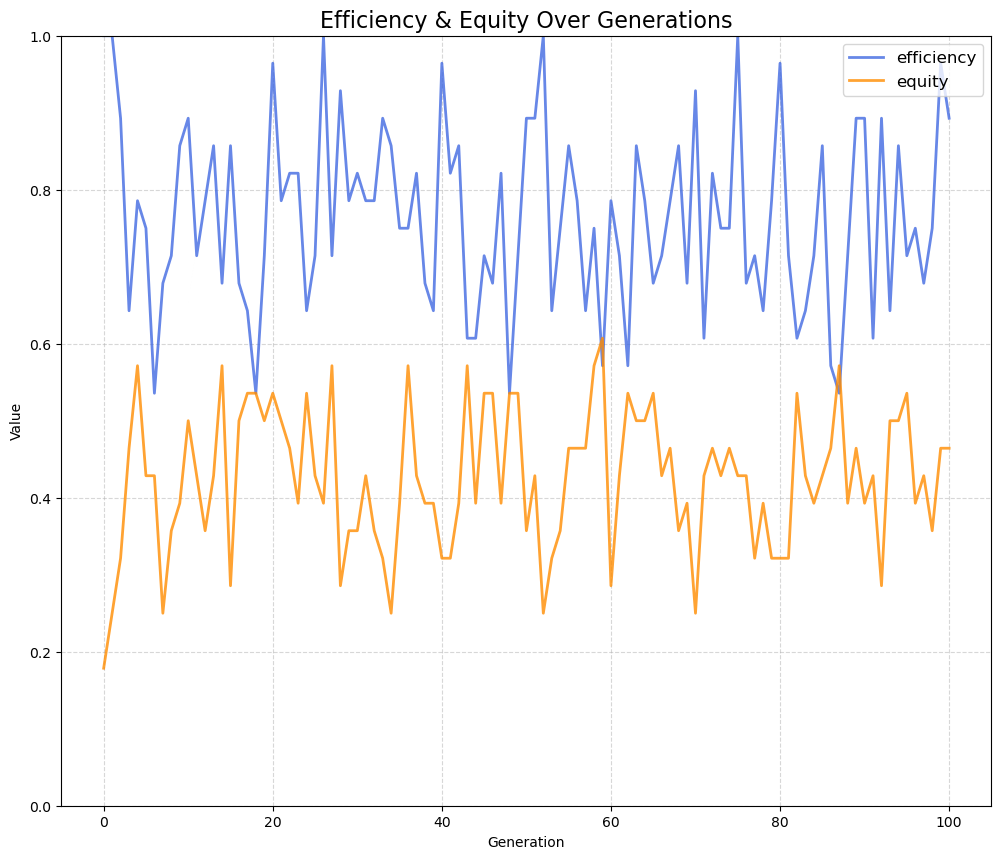

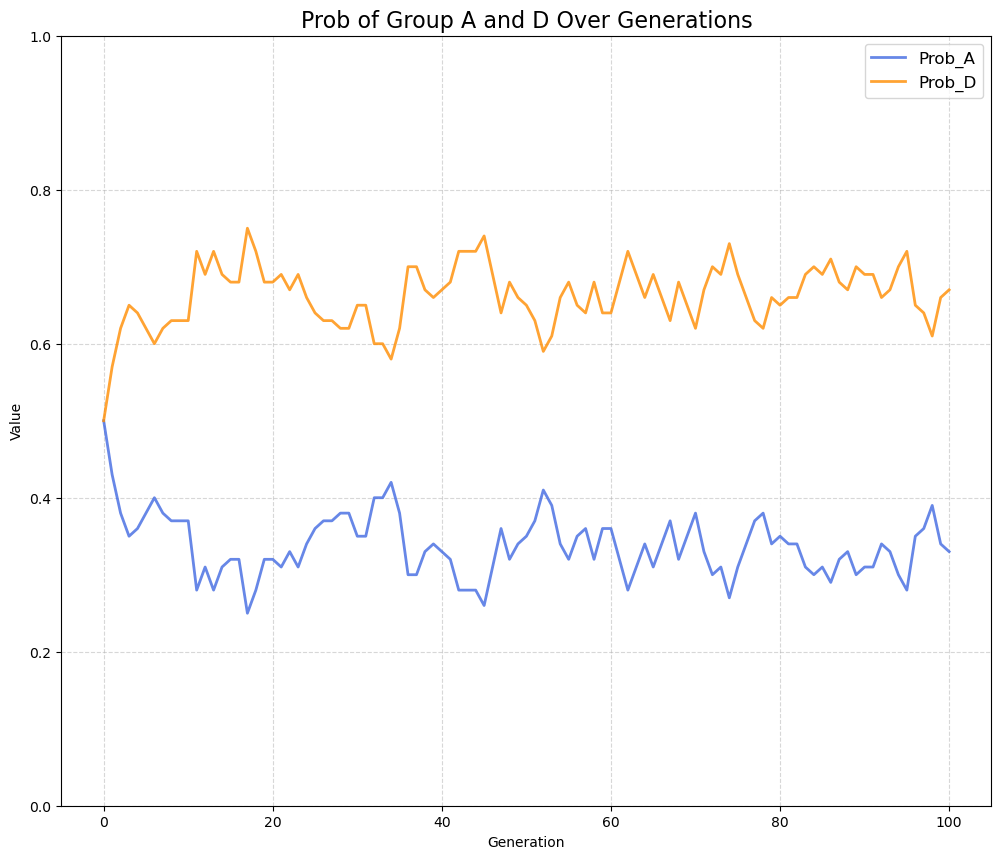

In [18]:
# Base model + Default scenario
df_1 = df_0.copy()
# Initial evaluation metrics for each generation
efficiency = [df_0.loc[df_0["admit"]==1,"f"].mean()] # mean f
equity = [df_0.loc[(df_0["admit"]==1) & (df_0["g"]=="D"),"g"].shape[0]/df_0.loc[df_0["admit"]==1,"g"].shape[0]] # fraction of admitted students from group D
prob_A = [df_0.loc[df_0["g"]=="A"].shape[0]/df_0.shape[0]] # fraction of students from group A
prob_D = [df_0.loc[df_0["g"]=="D"].shape[0]/df_0.shape[0]] # fraction of students from group D

for i in range(100):
    df_1 = run_admission_iter(parents_df= df_1, seed=i+8)
    #print(df_0.head())
    efficiency.append(df_1.loc[df_1["admit"]==1,"f"].mean())
    equity.append(df_1.loc[(df_1["admit"]==1) & (df_1["g"]=="D"),"g"].shape[0]/df_1.loc[df_1["admit"]==1,"g"].shape[0])
    prob_A.append(df_1.loc[df_1["g"]=="A"].shape[0]/df_1.shape[0])
    prob_D.append(df_1.loc[df_1["g"]=="D"].shape[0]/df_1.shape[0])

# for i in range(1000):
#     df_1 = run_admission_iter(students_df = df_1, seed=i+90)
#     efficiency.append(df_1.loc[df_1["admit"]==1,"f"].mean())
#     equity.append(df_1.loc[(df_1["admit"]==1) & (df_1["g"]=="D"),"g"].shape[0]/df_1.loc[df_1["admit"]==1,"g"].shape[0])
#     prob_A.append(df_1.loc[df_1["g"]=="A"].shape[0]/df_1.shape[0])
#     prob_D.append(df_1.loc[df_1["g"]=="D"].shape[0]/df_1.shape[0])

eval_df_00 = pd.DataFrame({"generation":range(len(efficiency)),"efficiency":efficiency,"equity":equity,"prob_A":prob_A,"prob_D":prob_D})

#eval_df_00.head(10)
print("**Results for Base model + Default scenario**")
plot_effi_eq(eval_df_00)
plot_groups_prob(eval_df_00)

### Base model + Scenario 2

** Results for Base model + Scenario 2 **


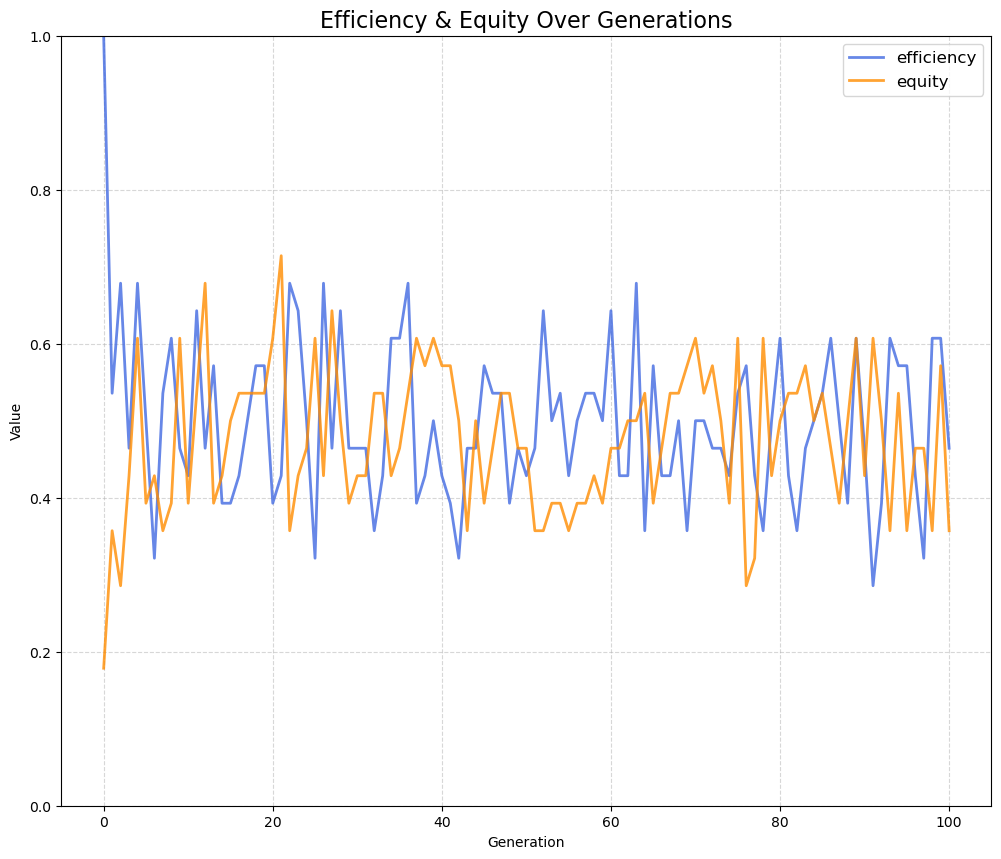

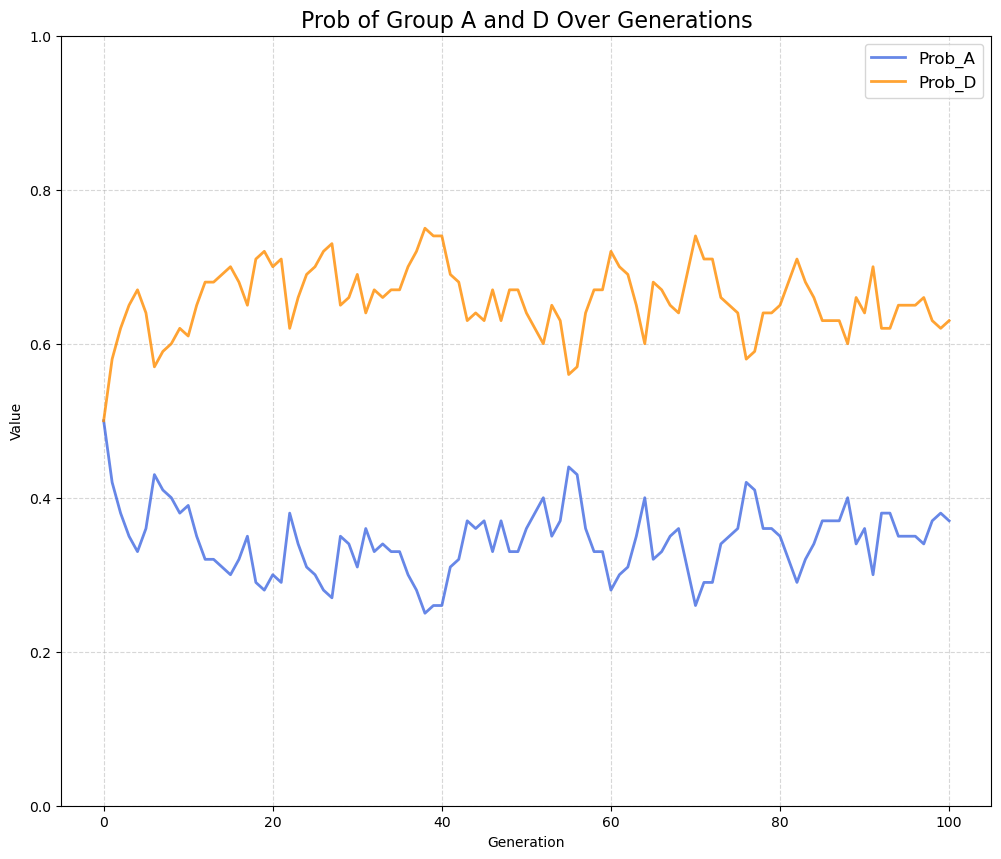

In [19]:
# Base model +  scenario2
df_1 = df_0.copy()
# Initial evaluation metrics for each generation
efficiency = [df_0.loc[df_0["admit"]==1,"f"].mean()] # mean f
equity = [df_0.loc[(df_0["admit"]==1) & (df_0["g"]=="D"),"g"].shape[0]/df_0.loc[df_0["admit"]==1,"g"].shape[0]] # fraction of admitted students from group D
prob_A = [df_0.loc[df_0["g"]=="A"].shape[0]/df_0.shape[0]] # fraction of students from group A
prob_D = [df_0.loc[df_0["g"]=="D"].shape[0]/df_0.shape[0]] # fraction of students from group D

for i in range(100):
    df_1 = run_admission_iter(parents_df = df_1, scenario="scenario_2",seed=i+8)
    #print(df_1.head())
    efficiency.append(df_1.loc[df_1["admit"]==1,"f"].mean())
    equity.append(df_1.loc[(df_1["admit"]==1) & (df_1["g"]=="D"),"g"].shape[0]/df_1.loc[df_1["admit"]==1,"g"].shape[0])
    prob_A.append(df_1.loc[df_1["g"]=="A"].shape[0]/df_1.shape[0])
    prob_D.append(df_1.loc[df_1["g"]=="D"].shape[0]/df_1.shape[0])

eval_df_01 = pd.DataFrame({"generation":range(len(efficiency)),"efficiency":efficiency,"equity":equity,"prob_A":prob_A,"prob_D":prob_D})

#eval_df_00.head(10)
print("** Results for Base model + Scenario 2 **")
plot_effi_eq(eval_df_01)
plot_groups_prob(eval_df_01)

### Base model + Scenario 3

** Results for Base model + Scenario 3 **


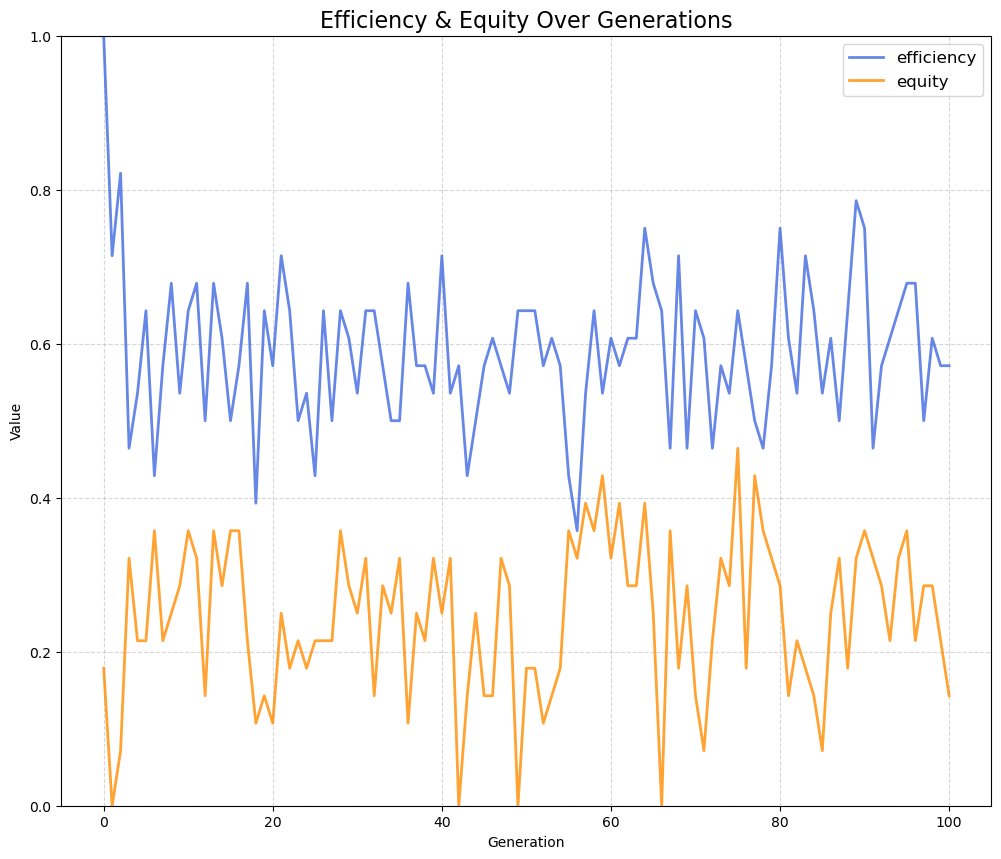

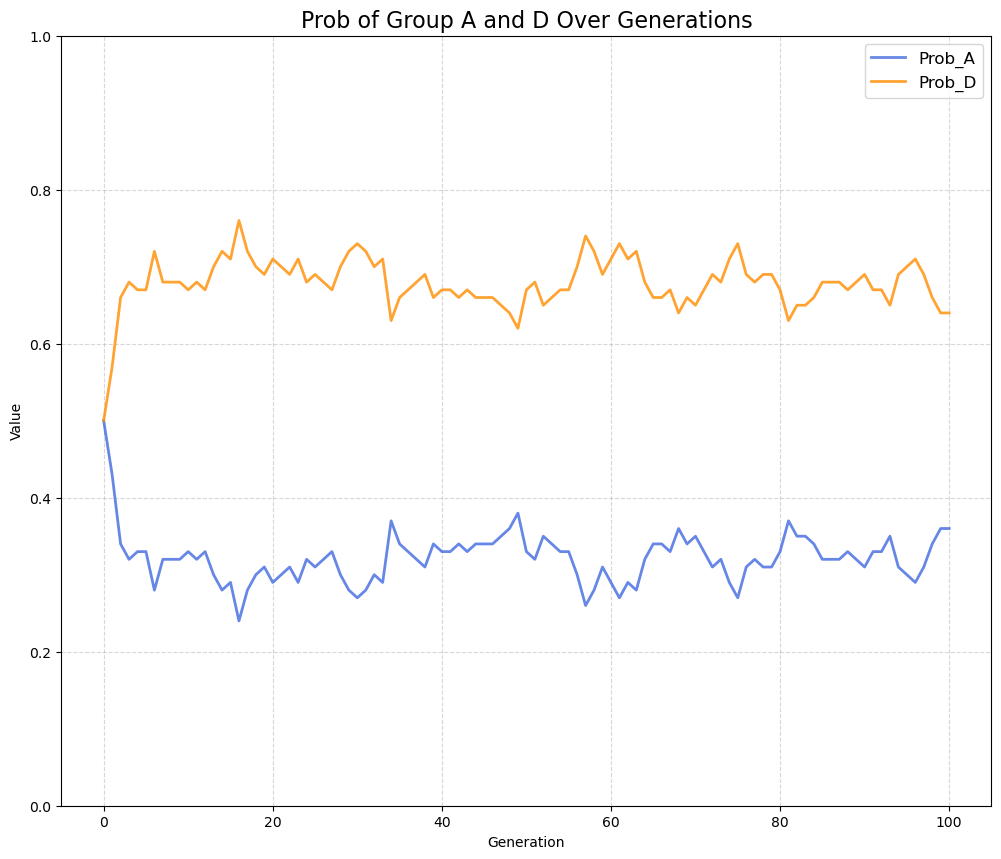

In [20]:
# Base model +  scenario3
df_1 = df_0.copy()
# Initial evaluation metrics for each generation
efficiency = [df_0.loc[df_0["admit"]==1,"f"].mean()] # mean f
equity = [df_0.loc[(df_0["admit"]==1) & (df_0["g"]=="D"),"g"].shape[0]/df_0.loc[df_0["admit"]==1,"g"].shape[0]] # fraction of admitted students from group D
prob_A = [df_0.loc[df_0["g"]=="A"].shape[0]/df_0.shape[0]] # fraction of students from group A
prob_D = [df_0.loc[df_0["g"]=="D"].shape[0]/df_0.shape[0]] # fraction of students from group D

for i in range(100):
    df_1 = run_admission_iter(parents_df = df_1, scenario="scenario_3",seed=i+8)
    #print(df_1.head())
    efficiency.append(df_1.loc[df_1["admit"]==1,"f"].mean())
    equity.append(df_1.loc[(df_1["admit"]==1) & (df_1["g"]=="D"),"g"].shape[0]/df_1.loc[df_1["admit"]==1,"g"].shape[0])
    prob_A.append(df_1.loc[df_1["g"]=="A"].shape[0]/df_1.shape[0])
    prob_D.append(df_1.loc[df_1["g"]=="D"].shape[0]/df_1.shape[0])

eval_df_02 = pd.DataFrame({"generation":range(len(efficiency)),"efficiency":efficiency,"equity":equity,"prob_A":prob_A,"prob_D":prob_D})

#eval_df_00.head(10)
print("** Results for Base model + Scenario 3 **")
plot_effi_eq(eval_df_02)
plot_groups_prob(eval_df_02)

### Base model + Scenario 4

** Results for Base model + Scenario 4 **


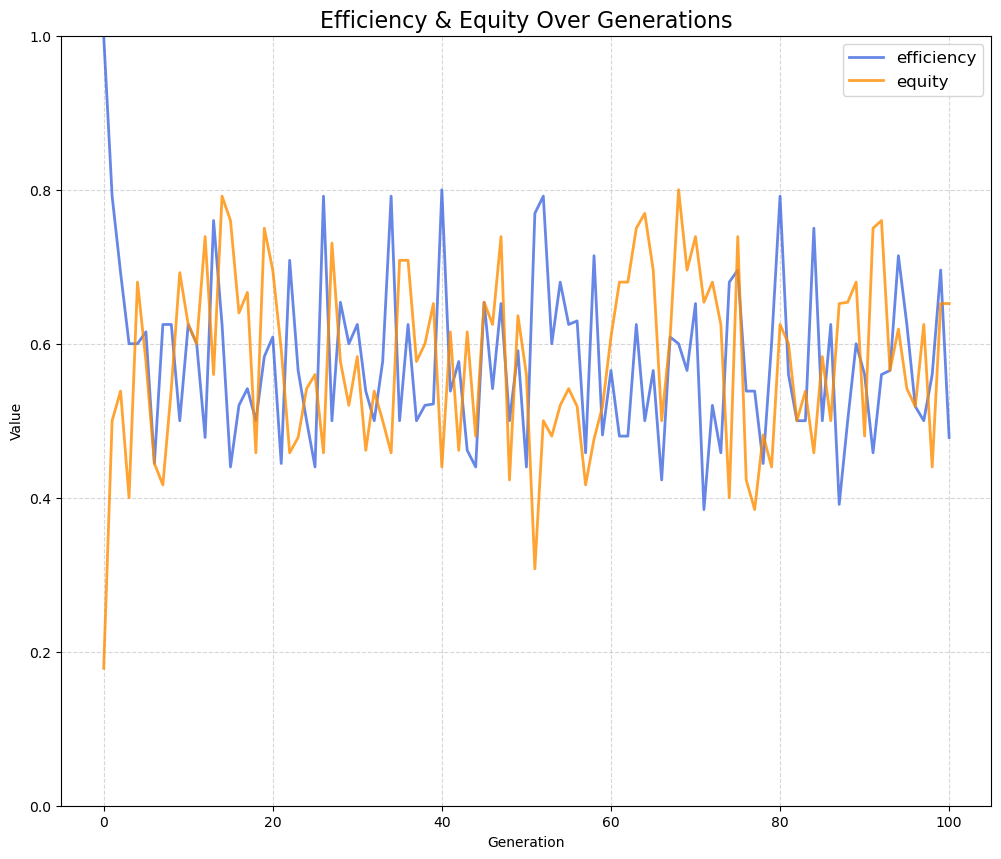

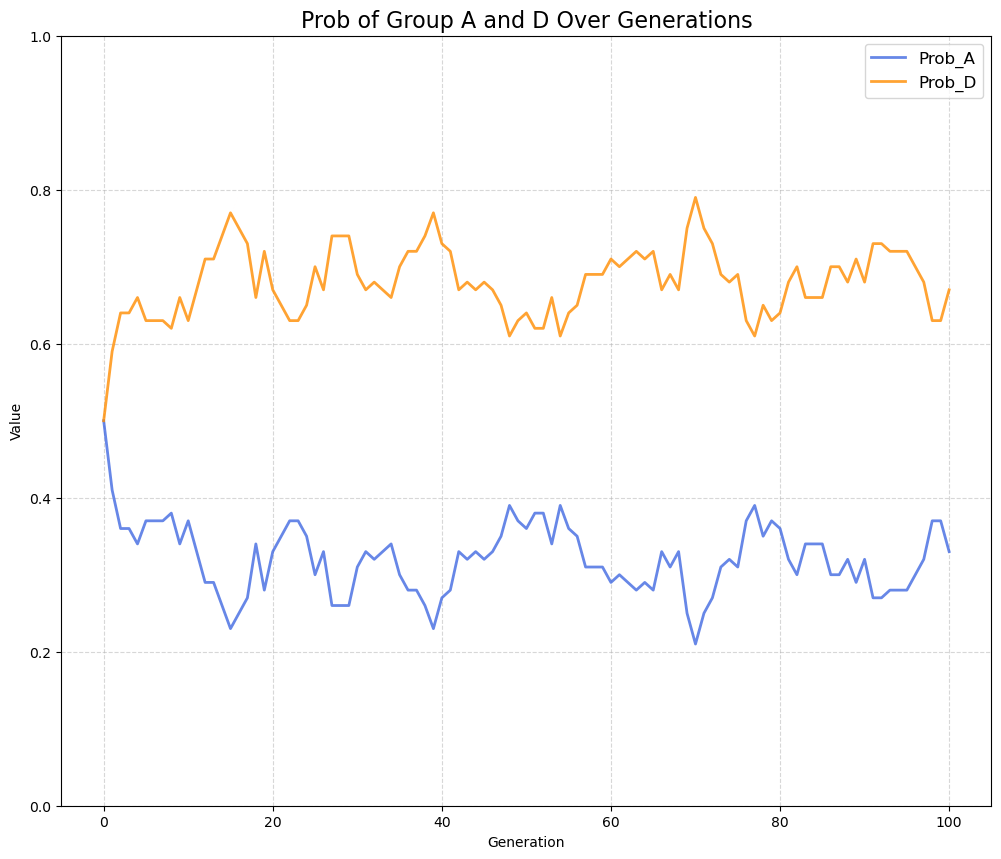

In [21]:
# Base model +  scenario3
df_1 = df_0.copy()
# Initial evaluation metrics for each generation
efficiency = [df_0.loc[df_0["admit"]==1,"f"].mean()] # mean f
equity = [df_0.loc[(df_0["admit"]==1) & (df_0["g"]=="D"),"g"].shape[0]/df_0.loc[df_0["admit"]==1,"g"].shape[0]] # fraction of admitted students from group D
prob_A = [df_0.loc[df_0["g"]=="A"].shape[0]/df_0.shape[0]] # fraction of students from group A
prob_D = [df_0.loc[df_0["g"]=="D"].shape[0]/df_0.shape[0]] # fraction of students from group D

for i in range(100):
    df_1 = run_admission_iter(parents_df = df_1, scenario="scenario_4",seed=i+8)
    #print(df_1.head())
    efficiency.append(df_1.loc[df_1["admit"]==1,"f"].mean())
    equity.append(df_1.loc[(df_1["admit"]==1) & (df_1["g"]=="D"),"g"].shape[0]/df_1.loc[df_1["admit"]==1,"g"].shape[0])
    prob_A.append(df_1.loc[df_1["g"]=="A"].shape[0]/df_1.shape[0])
    prob_D.append(df_1.loc[df_1["g"]=="D"].shape[0]/df_1.shape[0])

eval_df_03 = pd.DataFrame({"generation":range(len(efficiency)),"efficiency":efficiency,"equity":equity,"prob_A":prob_A,"prob_D":prob_D})

#eval_df_00.head(10)
print("** Results for Base model + Scenario 4 **")
plot_effi_eq(eval_df_03)
plot_groups_prob(eval_df_03)

### Model 2 + Default scenario

**Results for Model 2 + Default scenario**


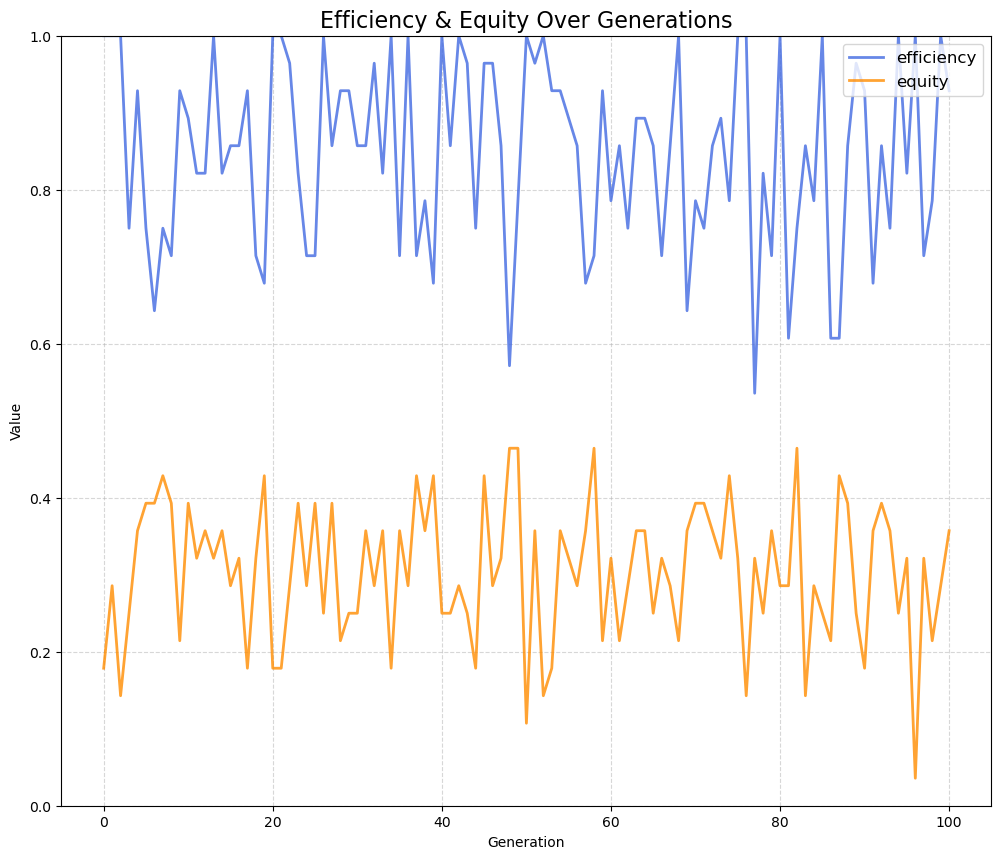

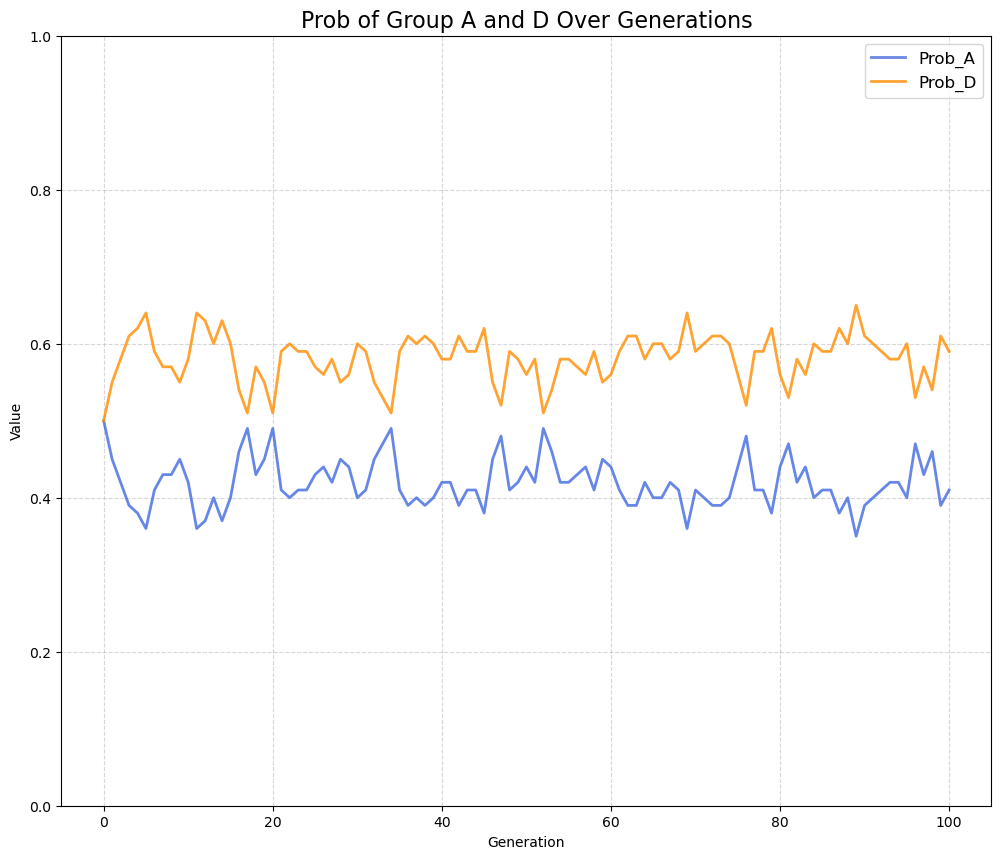

In [22]:
# Base model + Default scenario
df_1 = df_0.copy()
# Initial evaluation metrics for each generation
efficiency = [df_0.loc[df_0["admit"]==1,"f"].mean()] # mean f
equity = [df_0.loc[(df_0["admit"]==1) & (df_0["g"]=="D"),"g"].shape[0]/df_0.loc[df_0["admit"]==1,"g"].shape[0]] # fraction of admitted students from group D
prob_A = [df_0.loc[df_0["g"]=="A"].shape[0]/df_0.shape[0]] # fraction of students from group A
prob_D = [df_0.loc[df_0["g"]=="D"].shape[0]/df_0.shape[0]] # fraction of students from group D

for i in range(100):
    df_1 = run_admission_iter(parents_df = df_1, seed=i+8, upgrade_prob=0.83)
    #print(df_0.head())
    efficiency.append(df_1.loc[df_1["admit"]==1,"f"].mean())
    equity.append(df_1.loc[(df_1["admit"]==1) & (df_1["g"]=="D"),"g"].shape[0]/df_1.loc[df_1["admit"]==1,"g"].shape[0])
    prob_A.append(df_1.loc[df_1["g"]=="A"].shape[0]/df_1.shape[0])
    prob_D.append(df_1.loc[df_1["g"]=="D"].shape[0]/df_1.shape[0])

eval_df_10 = pd.DataFrame({"generation":range(len(efficiency)),"efficiency":efficiency,"equity":equity,"prob_A":prob_A,"prob_D":prob_D})

#eval_df_00.head(10)
print("**Results for Model 2 + Default scenario**")
plot_effi_eq(eval_df_10)
plot_groups_prob(eval_df_10)

### Model 3 + Default scenario

**Results for Model 3 + Default scenario**


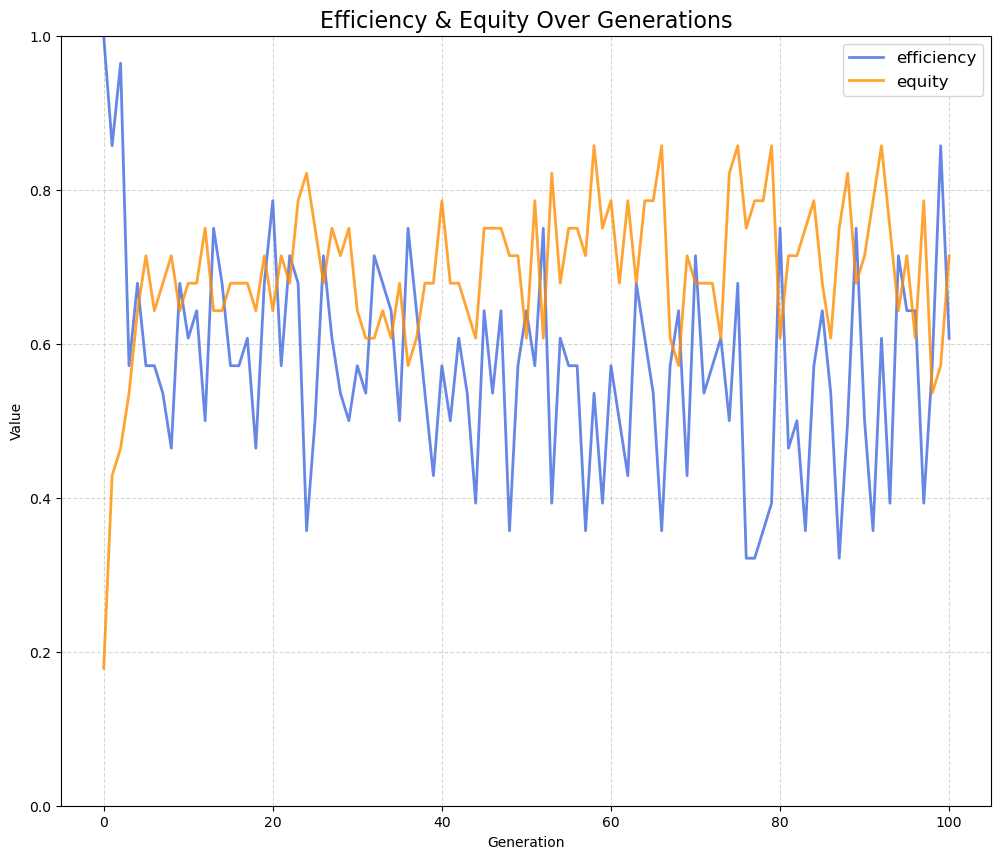

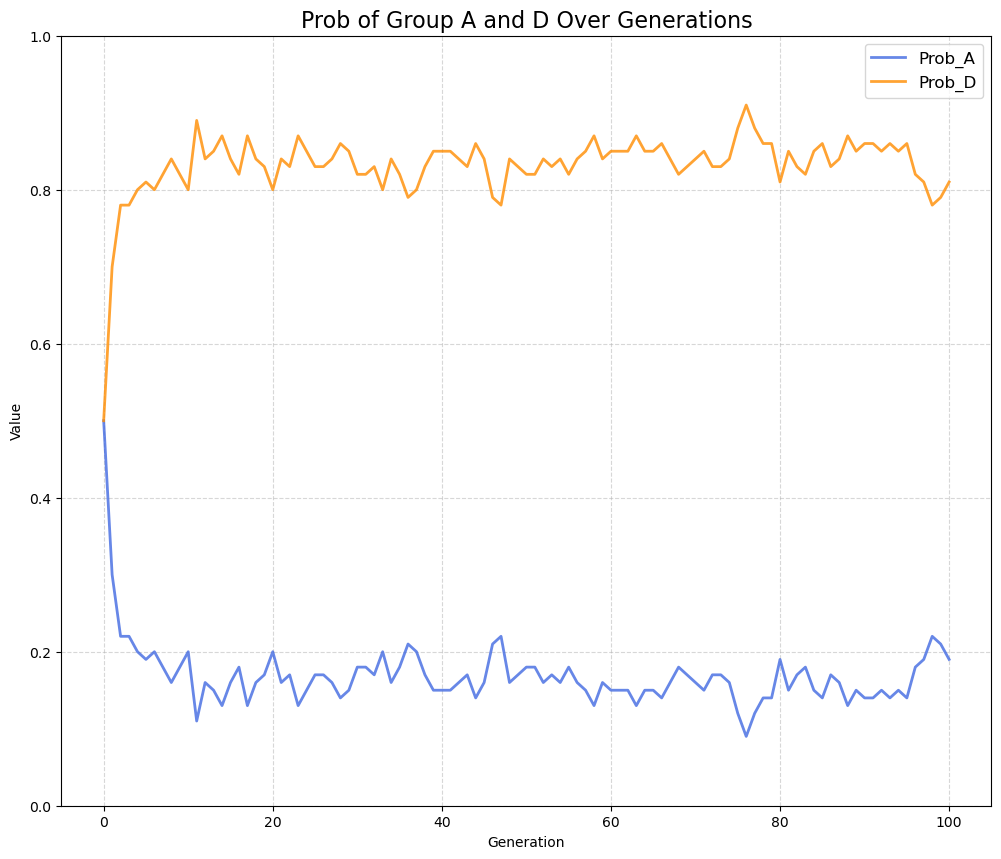

In [23]:
# Base model + Default scenario
df_1 = df_0.copy()
# Initial evaluation metrics for each generation
efficiency = [df_0.loc[df_0["admit"]==1,"f"].mean()] # mean f
equity = [df_0.loc[(df_0["admit"]==1) & (df_0["g"]=="D"),"g"].shape[0]/df_0.loc[df_0["admit"]==1,"g"].shape[0]] # fraction of admitted students from group D
prob_A = [df_0.loc[df_0["g"]=="A"].shape[0]/df_0.shape[0]] # fraction of students from group A
prob_D = [df_0.loc[df_0["g"]=="D"].shape[0]/df_0.shape[0]] # fraction of students from group D

for i in range(100):
    df_1 = run_admission_iter(parents_df = df_1, seed=i+8, upgrade_prob=0.33, degrade_prob=0.83)
    #print(df_0.head())
    efficiency.append(df_1.loc[df_1["admit"]==1,"f"].mean())
    equity.append(df_1.loc[(df_1["admit"]==1) & (df_1["g"]=="D"),"g"].shape[0]/df_1.loc[df_1["admit"]==1,"g"].shape[0])
    prob_A.append(df_1.loc[df_1["g"]=="A"].shape[0]/df_1.shape[0])
    prob_D.append(df_1.loc[df_1["g"]=="D"].shape[0]/df_1.shape[0])

eval_df_20 = pd.DataFrame({"generation":range(len(efficiency)),"efficiency":efficiency,"equity":equity,"prob_A":prob_A,"prob_D":prob_D})

#eval_df_00.head(10)
print("**Results for Model 3 + Default scenario**")
plot_effi_eq(eval_df_20)
plot_groups_prob(eval_df_20)

### Comparison

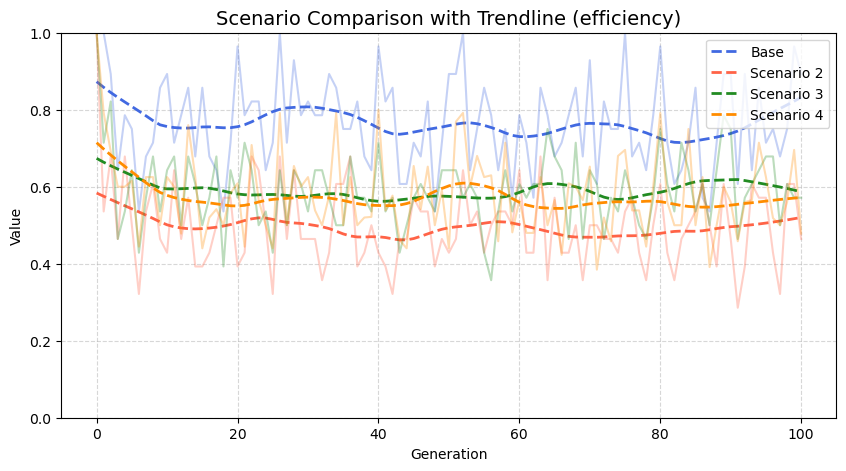

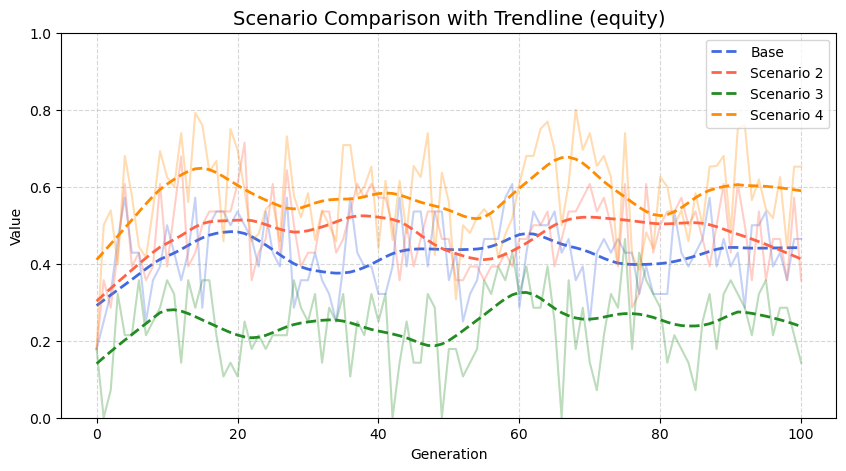

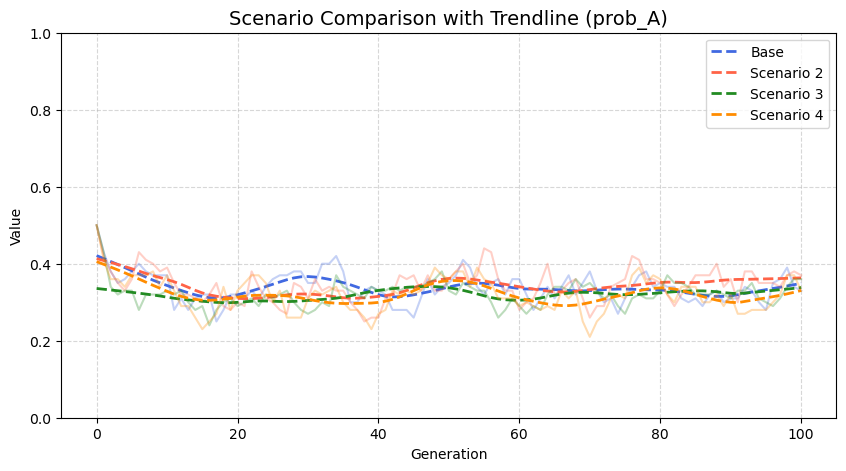

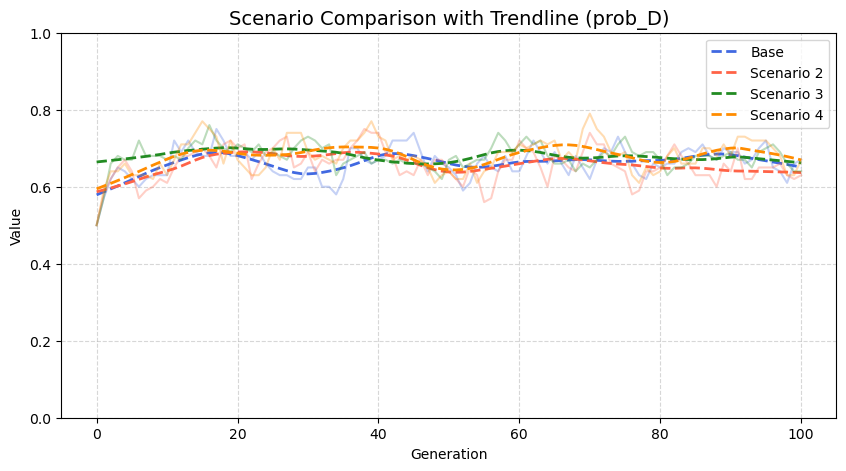

In [24]:
df_lst = [eval_df_00,eval_df_01,eval_df_02,eval_df_03]
plot_trendline_scenario(df_lst, var = "efficiency")

plot_trendline_scenario(df_lst, var = "equity")

plot_trendline_scenario(df_lst, var = "prob_A")
plot_trendline_scenario(df_lst, var = "prob_D")

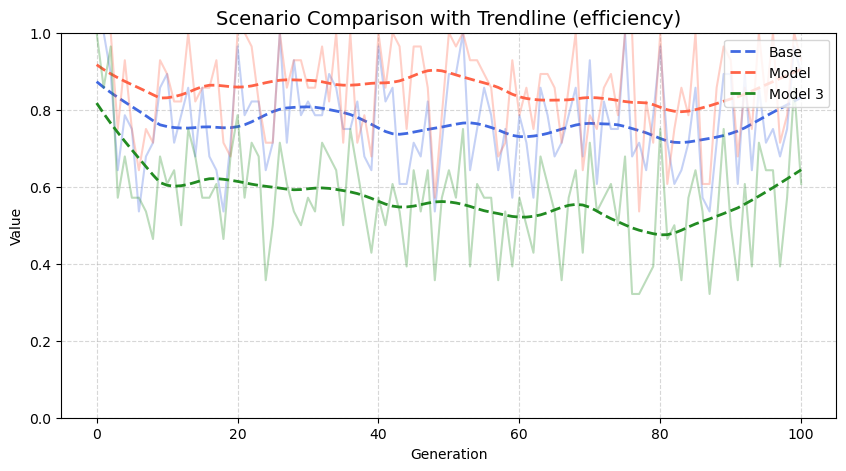

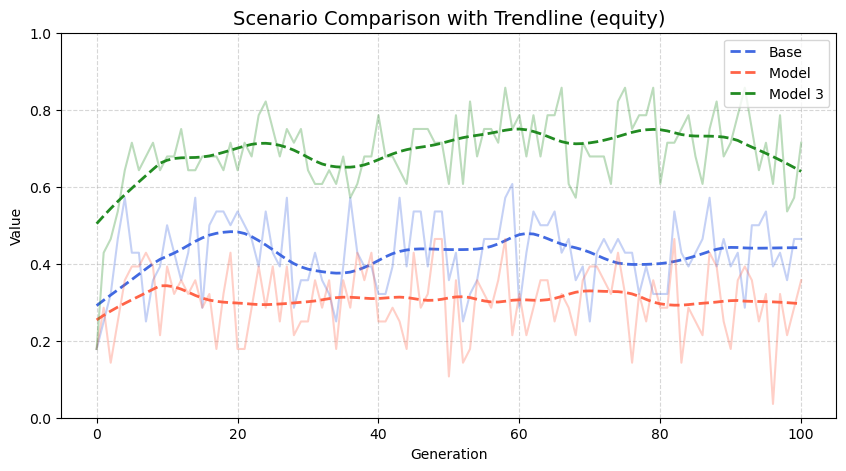

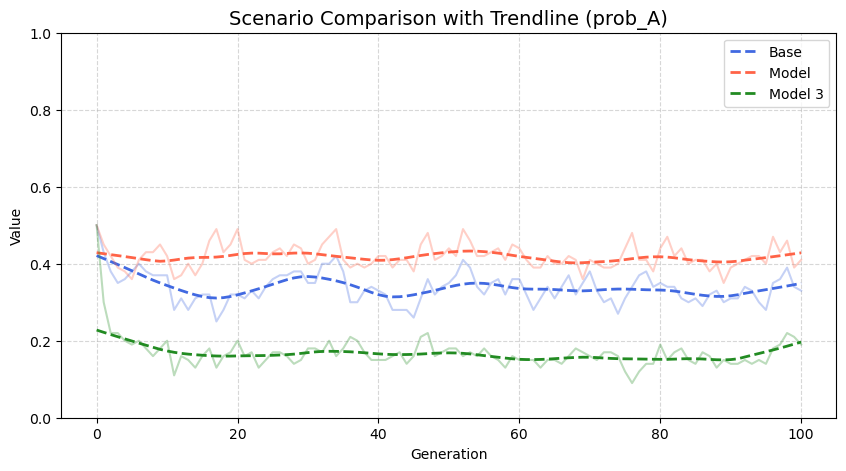

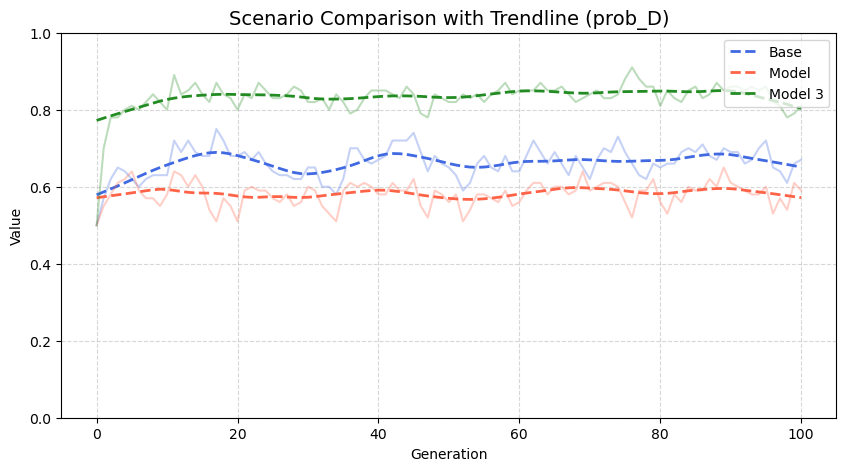

In [25]:
df_lst = [eval_df_00,eval_df_10,eval_df_20]
plot_trendline_model(df_lst, var = "efficiency")
plot_trendline_model(df_lst, var = "equity")

plot_trendline_model(df_lst, var = "prob_A")
plot_trendline_model(df_lst, var = "prob_D")